In [115]:
%load_ext jupyternotify
import numpy as np
import pandas as pd
import glob
import pickle
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [2]:
# Pickling functions used to save and load the dictionary file

def save_obj(obj, name):
    with open('dataset/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('dataset/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
# Importing UN data
data=[]
name=[]
for file_name in glob.glob('dataset/UNDP_HDI/*.csv'):
    data.append(pd.read_csv(file_name,
                             skiprows=0,
                             na_values="..",
                             na_filter=True,
                             header=1))
    name.append(file_name.split('/')[-1].split('.')[0])

# This snippet is for dealing with the format of the imported dataframes
for i in range(len(data)):
    for col in data[i].columns:
        # Drop columns containing 'Unnamed'
        if "Unnamed" in col: data[i].drop(labels=col, axis=1, inplace=True) 

In [4]:
data_train = pd.read_csv('dataset/train.csv')
data_test = pd.read_csv('dataset/test.csv')
columns_train = list(data_train.columns)

In [5]:
# Forming a complete list of all stripped entries in the Country column

full_list_dirty = set()
for i in range(len(data)):
    countries = [x for x in data[i].loc[:, 'Country'] if str(x) != 'nan']
    countries_stripped = set(map(lambda x: x.strip() , countries))
    full_list_dirty |= countries_stripped

# Filtering out non-countries in the column using
# manually found entries
entries_to_remove = set([
    'Arab States',
    'Developing Countries',
    'High human development',
    'Human Development',
    'Least Developed Countries',
    'Low human development',
    'Medium human development',
    'Organization for Economic Co-operation and Development',
    'Small Island Developing States',
    'South Asia',
    'Very high human development',
    'World',
    'East Asia and the Pacific',
    'Latin America and the Caribbean',
    'Regions',
    'Sub-Saharan Africa',
    'Europe and Central Asia',
    ])
full_list = full_list_dirty - entries_to_remove
full_list = sorted(list(full_list))
print(full_list)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic of the)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini (Kingdom of)', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong, China (SAR)', '

#### This code was used to collate 74 tables from the UNDP_HDI folder into one with a structure similar to that of Contest data (train/test.csv). However, the column order is different from that of the Contest—this is rectified later in this notebook
```python
# Running takes ~ 10-15 mins

# Firstly, strip country names of spaces that somehow got in there
for i in range(len(data)):
    for j, country in enumerate(data[i].loc[:, 'Country']):
        if str(country) != 'nan':
            data[i].loc[j, 'Country'] = country.strip()

# Collating UNDP tables into one compatible for comparison with
# the Contest one (train/test.csv)

table = []
for country in full_list:
#    print(country)
    for year in range(1990, 2018+1):
        row = [year, country]
        for df, nm in zip(data, name):
            df_ = df.set_index('Country')
            if (country in df_.index.dropna()) and (str(year) in df.columns):
                row.append(df_.loc[country, str(year)])
            else:
                row.append(np.nan)
        table.append(row)

undp_collated = pd.DataFrame(table,
                             columns=['year', 'country']+name).set_index(['year','country']).sort_index()
```

The following snippet was used to save undp_collated.csv
```python
undp_collated.to_csv('dataset/undp_collated.csv', na_rep='nan')
```

In [6]:
undp_collated = pd.read_csv('dataset/undp_collated.csv',
                            na_values='nan').set_index(['year', 'country'])

#### The following code was used to get a dictionary connecting column names from the UNDP table to the Contest data, e.g., "Human Development Index" -> "Intergalactic Development Index". This was done primarily to save time and to avoid doing it manually.
```python
# WARNING!------------------------------------------------------------------------
# This code snippet is not to be run if one wants to get a map
# of columns. In that case refer to the *pickled dictionary file* in the dataset
# folder. This is due to the manual corrections present later in this block, which
# are dependant on a certain sequence of columns from UN data, which in turn
# depends on the glob order. This load order might change on your run!

# This code is kept only to record my steps. 

import re

# Function str_comp compares how similar two strings are
# based on matching words or numbers.
# It returns a value from 0 to 1 (if duplicate words are present, it could be more than 1).
# 0 means strings lstr1 and lstr2 contain completely different words
# and the larger the metric — the better similarity. 
# It's very crude, but gets the job done relatively well for my purpose. 

def str_comp(lstr1, lstr2): # lstr1 and lstr2 are strings to be compared
    
    # Forming 2 lists of words from strings, 
    # ignoring all non alphabet/number symbols.
    # filter removes unnecessary blank strings in the list
    # left by re.split.
    l1 = list(filter(None, re.split(r'\W',lstr1)))
    l2 = list(filter(None, re.split(r'\W',lstr2)))
    
    # matchings DO account for duplicate words in one or both lists of strings,
    # in which case it inflates the final metric to more than 1.
    # Ideally it should be fixed, but it works fine for comparing strings. 
    matchings = 0
    for s1 in l1:
        for s2 in l2:
            if s1.lower() == s2.lower(): matchings+=1
    return matchings/max([len(l1), len(l2)])


# Making a list containing indices to match columns between datasets
# based on the str_comp function 'metric'
col_map=[]
for i, col1 in enumerate(name):
    maxim = 0
    j_m = 0
    for j, col2 in enumerate(columns_train):
        comp = str_comp(col1,col2)
        # This part checks whether this combination of list of strings col1 and col2
        # are more similar than the previous best in this loop. It also checks
        # that the second list of strings col2 has not appeared before in
        # col_map to avoid duplicates. 
        if (comp >= maxim) and (j not in [x[1] for x in col_map]): 
            maxim = comp
            j_m = j
    col_map.append((i, j_m))

# Manually fixing mistakes made by the mapping script
# NOTE! This manual corrections may change on different loads of the data
#
# Please, use the columns dict pickle file in the dataset folder 
# for final mapping. 

corrections = {
    (37, 72): (37, 8),
    (43, 78): (43, 72),
    (56, 41): (56, 42),
    (57, 8): (57, 78),
    (10, 42): (10,41),
}

# Final list with corrections:
col_map_corr = [corrections.get(x,x) for x in col_map]

# Now it's nice and dandy
for i, j in col_map_corr:
    print(i, name[i])
    print(j, columns_train[j], '\n')
```

#### This code was used to save the pickled dict.  
```python
col_map_abs = {}
for i, j in col_map_corr:
    col_map_abs[name[i].strip()] = columns_train[j].strip()

save_obj(col_map_abs, 'column_dict_from_UN_to_Contest_format')
```

In [7]:
# Final dictionary for column names from UNDP to Contest
col_map_abs = load_obj('column_dict_from_UN_to_Contest_format')

col_map_abs

{'Education Index': 'Education Index',
 'Employment to population ratio (% ages 15 and older)': 'Employment to population ratio (% ages 15 and older)',
 'Population, ages 65 and older (millions)': 'Population, ages 65 and older (millions)',
 'Mortality rate, infant (per 1,000 live births)': 'Mortality rate, infant (per 1,000 live births)',
 'Human Development Index (HDI), female': 'Intergalactic Development Index (IDI), female',
 'Estimated gross national income per capita, female (2011 PPP$)': 'Estimated gross galactic income per capita, female',
 'Share of seats in parliament (% held by women)': 'Share of seats in senate (% held by female)',
 'Labour force participation rate (% ages 15 and older), male': 'Labour force participation rate (% ages 15 and older), male',
 'Remittances, inflows (% of GDP)': 'Remittances, inflows (% of GGP)',
 'International inbound tourists (thousands)': 'Intergalactic inbound tourists (thousands)',
 'Infants lacking immunization, measles (% of one-year-ol

In [23]:
# Inverse dictionary of col_map_abs: Contest column names -> UNDP column names
col_map_abs_inv = {v: k for k, v in col_map_abs.items()}

# Set undp_collated columns in the correct order
undp_order = [col_map_abs_inv.get(x) for x in data_train_cl.columns]
undp_clean = undp_collated[undp_order]

In [24]:
undp_clean

Life expectancy Index  \
year country                                                     
1990 Afghanistan                                         0.467   
     Albania                                             0.797   
     Algeria                                             0.722   
     Andorra                                             0.870   
     Angola                                              0.389   
...                                                        ...   
2018 Venezuela (Bolivarian Republic of)                  0.802   
     Viet Nam                                            0.851   
     Yemen                                               0.709   
     Zambia                                              0.669   
     Zimbabwe                                            0.634   

                                         Life expectancy at birth  \
year country                                                        
1990 Afghanistan                                             50.3   
     Albania                                                 71.8   
     Algeria                                                 66.9   
     Andorra                                                 76.5   
     Angola                                                  45.3   
...                                                           ...   
2018 Venezuela (Bolivarian Republic of)                      72.1   
     Viet Nam                                                75.3   
     Yemen                                                   66.1   
     Zambia                                                  63.5   
     Zimbabwe                                                61.2   

                                         Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                                                  
1990 Afghanistan                                                                    2193.0    
     Albania                                                                        4415.0    
     Algeria                                                                        9989.0    
     Andorra                                                                       49062.0    
     Angola                                                                         4139.0    
...                                                                                    ...    
2018 Venezuela (Bolivarian Republic of)                                             9070.0    
     Viet Nam                                                                       6220.0    
     Yemen                                                                          1433.0    
     Zambia                                                                         3582.0    
     Zimbabwe                                                                       2661.0    

                                         Income Index  \
year country                                            
1990 Afghanistan                                0.466   
     Albania                                    0.572   
     Algeria                                    0.695   
     Andorra                                    0.936   
     Angola                                     0.562   
...                                               ...   
2018 Venezuela (Bolivarian Republic of)         0.681   
     Viet Nam                                   0.624   
     Yemen                                      0.402   
     Zambia                                     0.541   
     Zimbabwe                                   0.496   

                                         Expected years of schooling (years)  \
year country                                                                   
1990 Afghanistan                                                         2.6   
     Albania                                                      

Code used to save undp_clean
```python
# Saving undp_clean
undp_clean.to_csv('dataset/undp_clean.csv', na_rep='nan')
```

In [10]:
# Get a list of unique galactic years
unique_years = data_train['galactic year'].unique()
print (unique_years)
print (unique_years.shape)

# Get a list of unique galaxy names
unique_names = data_train['galaxy'].unique()
unique_names = np.sort(unique_names)
print (unique_names[:5])
print (unique_names.shape)

# Let's map all galactic years to human years with an increment 
# of 1 year starting from year 1990

# Dictionary for replacement of galactic years with normal years.
# Year 1016064 is added to the unique_years since this year is not present
# in the train set, but it is in the test set. 
di = {val: ind+1990 for ind, val in enumerate(np.append(unique_years,
                                                     1016064))}

[ 990025  991020  992016  993012  994009  995006  996004  997002  998001
  999000 1000000 1001000 1002001 1003002 1004004 1005006 1006009 1007012
 1008016 1009020 1010025 1011030 1012036 1013042 1014049 1015056]
(26,)
['Andromeda Galaxy (M31)' 'Andromeda I' 'Andromeda II' 'Andromeda III'
 'Andromeda IX']
(181,)


In [11]:
# Preparing train and test set to compare with the UNDP dataset. I dropped some columns 
# since I believe the HDI Ranks for the year from which the original 
# Contest dataset was pulled might be different from the one in 2018

data_train_cl = data_train.replace({'galactic year':di})
data_train_cl = data_train_cl.set_index(['galactic year', 'galaxy']).drop(
    labels=
    [
        'Intergalactic Development Index (IDI), Rank',
        'Intergalactic Development Index (IDI), female, Rank',
        'Intergalactic Development Index (IDI), male, Rank',
        'y'
    ],
    axis=1)

# Same for the test set
data_test_cl = data_test.replace({'galactic year':di})
data_test_cl = data_test_cl.set_index(['galactic year', 'galaxy']).drop(
    labels=
    [
        'Intergalactic Development Index (IDI), Rank',
        'Intergalactic Development Index (IDI), female, Rank',
        'Intergalactic Development Index (IDI), male, Rank',
    ],
    axis=1)

## 14.06 Tinkering starts here

In [288]:
undp_clean.groupby(level=1)['Gross national income (GNI) per capita (2011 PPP$)'].mean().sort_values().tail(10)

country
Luxembourg                              70483.379310
Kuwait                                  82010.068966
Brunei Darussalam                       82474.758621
Liechtenstein                           84774.551724
United Arab Emirates                    86467.827586
Qatar                                  100280.793103
Korea (Democratic People's Rep. of)              NaN
Monaco                                           NaN
San Marino                                       NaN
Somalia                                          NaN
Name: Gross national income (GNI) per capita (2011 PPP$), dtype: float64

In [286]:
data_train_cl_no_world.groupby(level=1)['Gross income per capita'].mean().sort_values().tail(10)

galaxy
NGC 4163 (NGC 4167)                61913.313908
NGC 5237                           64935.709143
MB 3                               67788.660471
KK98 35                            71319.805602
ESO 294-010                        73737.109766
Tucana Dwarf                       88805.521680
Perseus I (Andromeda XXXIII)       98798.934029
Ursa Minor Dwarf                  102608.503189
Holmberg II (DDO 50, UGC 4305)    110196.993692
KKh 086                           114590.972203
Name: Gross income per capita, dtype: float64

In [187]:
undp_clean[undp_clean['Population, total (millions)']>300]['Population, total (millions)']

year  country      
1990  China            1176.9
      India             873.3
1995  China            1240.9
      India             963.9
2000  China            1290.6
      India            1056.6
2005  China            1330.8
      India            1147.6
2010  China            1368.8
      India            1234.3
      United States     309.0
2011  China            1376.5
      India            1250.3
      United States     311.6
2012  China            1384.2
      India            1265.8
      United States     314.0
2013  China            1391.9
      India            1280.8
      United States     316.4
2014  China            1399.5
      India            1295.6
      United States     318.7
2015  China            1406.8
      India            1310.2
      United States     320.9
2016  China            1414.0
      India            1324.5
      United States     323.0
2017  China            1421.0
      India            1338.7
      United States     325.1
2018  China         

In [205]:
data_train_cl_no_world[data_train_cl_no_world['Population, total (millions)']>1500]

existence expectancy index  \
galactic year galaxy                                                      
1990          Andromeda XXVI                                   0.678498   
              Phoenix II                                       0.952909   
1995          Phoenix II                                       0.922333   
2000          Phoenix II                                       0.946343   
              Andromeda XXVI                                   0.839765   
2005          Phoenix II                                       0.975695   
              Andromeda XXVI                                   0.765746   
2010          Andromeda XX                                     1.008997   
2011          Sagittarius Dwarf Sphr SagDEG                    0.976631   
2013          Phoenix II                                       1.036667   
2014          Phoenix II                                       0.904959   
2015          Andromeda XXVI                                   0.850204   

                                             existence expectancy at birth  \
galactic year galaxy                                                         
1990          Andromeda XXVI                                     60.160352   
              Phoenix II                                         75.959963   
1995          Phoenix II                                         78.393923   
2000          Phoenix II                                         81.020079   
              Andromeda XXVI                                     73.409512   
2005          Phoenix II                                         88.841210   
              Andromeda XXVI                                     72.233407   
2010          Andromeda XX                                       80.078686   
2011          Sagittarius Dwarf Sphr SagDEG                      85.091917   
2013          Phoenix II                                         80.686026   
2014          Phoenix II                                         86.354594   
2015          Andromeda XXVI                                     78.826137   

                                             Gross income per capita  \
galactic year galaxy                                                   
1990          Andromeda XXVI                            15190.567130   
              Phoenix II                                26557.505620   
1995          Phoenix II                                10169.550893   
2000          Phoenix II                                26436.072777   
              Andromeda XXVI                            14578.189439   
2005          Phoenix II                                21438.092977   
              Andromeda XXVI                            31000.310747   
2010          Andromeda XX                              19704.676733   
2011          Sagittarius Dwarf Sphr SagDEG             34884.177526   
2013          Phoenix II                                34878.720462   
2014          Phoenix II                                30703.894330   
2015          Andromeda XXVI                            14153.047087   

                                             Income Index  \
galactic year galaxy                                        
1990          Andromeda XXVI                     0.582529   
              Phoenix II                         0.600758   
1995          Phoenix II                         0.630508   
2000          Phoenix II                         0.687468   
              Andromeda XXVI                     0.721789   
2005          Phoenix II                         0.887763   
              Andromeda XXVI                     0.743089   
2010          Andromeda XX                       0.583766   
2011          Sagittarius Dwarf Sphr SagDEG      0.922887   
2013          Phoenix II                         0.969781   
2014          Phoenix II                         0.859733   
2015          Andromeda XXVI                     0.813188   

                                     

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f222a5e6090>]],
      dtype=object)

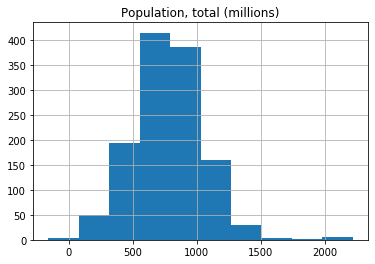

In [174]:
data_train_cl_no_world.hist(column='Population, total (millions)')

In [285]:
gal_slice = data_train_cl_no_world.loc[(slice(None), 'Coma Berenices Dwarf'),]
years_to_comp = [year for year, gal in gal_slice.index]
gal_slice.mean(axis=0) 

existence expectancy index                                                       0.920811
existence expectancy at birth                                                   79.444125
Gross income per capita                                                      27762.269985
Income Index                                                                     0.842268
Expected years of education (galactic years)                                    17.271369
                                                                                 ...     
Gender Development Index (GDI)                                                   1.102985
Adjusted net savings                                                            26.723694
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total        4.487815
Private galaxy capital flows (% of GGP)                                         25.625493
Gender Inequality Index (GII)                                                    0.345841
Length: 74

In [240]:
shift = [p2-p1 for p1, p2 in peaks]
shift = np.array(shift)

In [277]:
undp_clean.loc[idx[years_to_comp, 'United States'],].mean(axis=0) + shift

Life expectancy Index                                     1.017932
Life expectancy at birth                                 86.899093
Gross national income (GNI) per capita (2011 PPP$)    63725.950946
Income Index                                              1.079375
Expected years of schooling (years)                      18.633453
                                                          ...     
Gender Development Index (GDI)                            1.068989
Adjusted net savings (% of GNI)                          20.646463
HIV prevalence, adult (% ages 15-49), total                    NaN
Private capital flows (% of GDP)                         25.503638
Gender Inequality Index (GII)                             0.454677
Length: 74, dtype: float64

In [287]:
undp_clean

Life expectancy Index  \
year country                                                     
1990 Afghanistan                                         0.467   
     Albania                                             0.797   
     Algeria                                             0.722   
     Andorra                                             0.870   
     Angola                                              0.389   
...                                                        ...   
2018 Venezuela (Bolivarian Republic of)                  0.802   
     Viet Nam                                            0.851   
     Yemen                                               0.709   
     Zambia                                              0.669   
     Zimbabwe                                            0.634   

                                         Life expectancy at birth  \
year country                                                        
1990 Afghanistan                                             50.3   
     Albania                                                 71.8   
     Algeria                                                 66.9   
     Andorra                                                 76.5   
     Angola                                                  45.3   
...                                                           ...   
2018 Venezuela (Bolivarian Republic of)                      72.1   
     Viet Nam                                                75.3   
     Yemen                                                   66.1   
     Zambia                                                  63.5   
     Zimbabwe                                                61.2   

                                         Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                                                  
1990 Afghanistan                                                                    2193.0    
     Albania                                                                        4415.0    
     Algeria                                                                        9989.0    
     Andorra                                                                       49062.0    
     Angola                                                                         4139.0    
...                                                                                    ...    
2018 Venezuela (Bolivarian Republic of)                                             9070.0    
     Viet Nam                                                                       6220.0    
     Yemen                                                                          1433.0    
     Zambia                                                                         3582.0    
     Zimbabwe                                                                       2661.0    

                                         Income Index  \
year country                                            
1990 Afghanistan                                0.466   
     Albania                                    0.572   
     Algeria                                    0.695   
     Andorra                                    0.936   
     Angola                                     0.562   
...                                               ...   
2018 Venezuela (Bolivarian Republic of)         0.681   
     Viet Nam                                   0.624   
     Yemen                                      0.402   
     Zambia                                     0.541   
     Zimbabwe                                   0.496   

                                         Expected years of schooling (years)  \
year country                                                                   
1990 Afghanistan                                                         2.6   
     Albania                                                      

In [62]:
i = 23
print(name[i])
data[i]

Gross domestic product (GDP), total (2011 PPP $ billions)


,HDI Rank (2018),Country,1990,1995,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,170,Afghanistan,NaN,NaN,NaN,28.2,48.8,49.0,55.2,58.3,59.9,60.8,62.2,63.8,64.5
1,69,Albania,14.7,13.2,16.8,22.4,28.9,29.7,30.1,30.4,30.9,31.6,32.7,33.9,35.3
2,82,Algeria,265.3,268.7,318.4,410.2,464.9,478.3,494.4,508.1,527.4,547.2,565.3,574.3,586.4
3,149,Angola,56.4,47.5,63.8,99.4,148.6,153.7,166.8,175.1,183.6,185.3,180.5,180.2,176.4
4,74,Antigua and Barbuda,1.1,1.2,1.6,1.8,1.8,1.8,1.8,1.8,1.9,2.0,2.1,2.2,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,,World,46138.0,52010.1,62551.7,75346.2,90126.2,93694.5,96816.9,100141.6,103664.2,107221.7,110853.5,115024.7,119217.8
209,a: Refers to 2017.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,b: Refers to 2016.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,c: Refers to 2014.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
data_train_cl_no_world = data_train_cl.drop(labels='NGC 1560', axis=0, level=1)

In [91]:
data_train_cl_no_world

existence expectancy index  \
galactic year galaxy                                                     
1990          Large Magellanic Cloud (LMC)                    0.628657   
              Camelopardalis B                                0.818082   
              Virgo I                                         0.659443   
              UGC 8651 (DDO 181)                              0.555862   
              Tucana Dwarf                                    0.991196   
...                                                                ...   
2015          Columba I                                       1.029704   
              Leo II Dwarf (Leo B, DDO 93)                    0.937869   
              Canes Venatici I Dwarf                          1.036144   
              KKs 3                                           0.939034   
              NGC 5237                                        1.032244   

                                            existence expectancy at birth  \
galactic year galaxy                                                        
1990          Large Magellanic Cloud (LMC)                      63.125200   
              Camelopardalis B                                  81.004994   
              Virgo I                                           59.570534   
              UGC 8651 (DDO 181)                                52.333293   
              Tucana Dwarf                                      81.802464   
...                                                                   ...   
2015          Columba I                                         82.832063   
              Leo II Dwarf (Leo B, DDO 93)                      75.877098   
              Canes Venatici I Dwarf                            93.540275   
              KKs 3                                             78.274427   
              NGC 5237                                          91.641356   

                                            Gross income per capita  \
galactic year galaxy                                                  
1990          Large Magellanic Cloud (LMC)             27109.234310   
              Camelopardalis B                         30166.793958   
              Virgo I                                   8441.707353   
              UGC 8651 (DDO 181)                                NaN   
              Tucana Dwarf                             81033.956906   
...                                                             ...   
2015          Columba I                                34310.471408   
              Leo II Dwarf (Leo B, DDO 93)             36899.067719   
              Canes Venatici I Dwarf                   37002.977875   
              KKs 3                                    28180.459770   
              NGC 5237                                 73109.215949   

                                            Income Index  \
galactic year galaxy                                       
1990          Large Magellanic Cloud (LMC)      0.646039   
              Camelopardalis B                  0.852246   
              Virgo I                           0.499762   
              UGC 8651 (DDO 181)                     NaN   
              Tucana Dwarf                      1.131163   
...                                                  ...   
2015          Columba I                         0.855094   
              Leo II Dwarf (Leo B, DDO 93)      0.929494   
              Canes Venatici I Dwarf            1.085245   
              KKs 3                             0.687655   
              NGC 5237                          1.207746   

                                            Expected years of education (galactic years)  \
galactic year galaxy                                                                       
1990          Large Magellanic Cloud (LMC)                                      8.240543   
              Camelopardalis B                                                 10.671823   
      

## 14.06 Tinkering ends here

Saving dataframes data_train_cl and data_test_cl
```python
# Saving 
data_train_cl.to_csv('dataset/data_train_cl.csv', na_rep='nan')
data_test_cl.to_csv('dataset/data_test_cl.csv', na_rep='nan')
```

TODO: find where to put this snippet, so that it makes sense

```python
undp_test = undp_clean.loc[data_test_cl.rename(galaxy_to_country).index]
undp_test = undp_test.drop(labels='y', axis=1)

undp_test.to_csv('dataset/undp_test.csv', na_rep='nan')
```

In [262]:
# For loading 
undp_clean = pd.read_csv('dataset/undp_clean.csv', na_values='nan').set_index(['year', 'country'])
data_train_cl = pd.read_csv('dataset/data_train_cl.csv', na_values='nan').set_index(['galactic year', 'galaxy'])

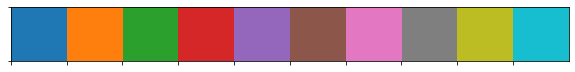

In [163]:
sns.palplot(sns.color_palette())

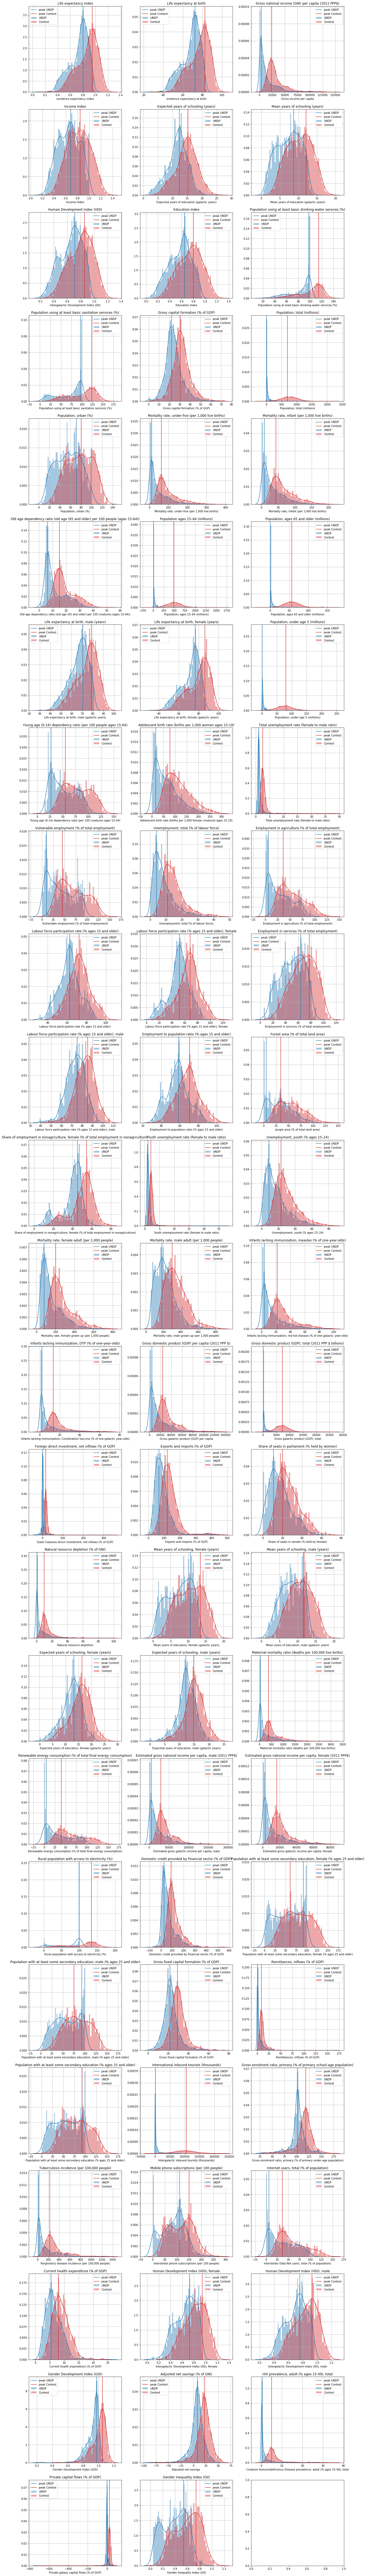

In [232]:
# Plots of UNDP attributes vs Contest attributes
from scipy.stats import gaussian_kde

# Seaborn default palette
colors = sns.color_palette()

# Drop the galaxy corresponding to the "World"
data_train_cl_no_world = data_train_cl.drop(labels='NGC 1560', axis=0, level=1)

# Slice undp_clean to keep years up until 2016
idx = pd.IndexSlice
undp_reduced = undp_clean.loc[idx[1990:2016, :],]

# List to keep track of peak1 and peak2 — modes of distributions
peaks = []

fig, axes = plt.subplots(25, 3, figsize=(21, 7*25))
for i in range(len(undp_reduced.columns)):
    ax = axes[i // 3, i % 3]
    hist1 = sns.distplot(undp_reduced.iloc[:, i], color=colors[0], label='UNDP', bins=50, ax=ax)
    hist2 = sns.distplot(data_train_cl_no_world.iloc[:, i], color=colors[3],  label='Contest', bins=50, ax=ax)
# Estimating modes of distributions yielded by KDE
    kde1 = gaussian_kde(undp_reduced.iloc[:, i].dropna(), bw_method='scott')
    kde2 = gaussian_kde(data_train_cl_no_world.iloc[:, i].dropna(), bw_method='scott')
    
    x1 = np.linspace(undp_reduced.iloc[:, i].dropna().min(),
                    undp_reduced.iloc[:, i].dropna().max(),
                    num=1000)
    x2 = np.linspace(data_train_cl_no_world.iloc[:, i].dropna().min(),
                    data_train_cl_no_world.iloc[:, i].dropna().max(),
                    num=1000)
    peak1 = x1[np.argmax(kde1.pdf(x1))]
    peak2 = x2[np.argmax(kde2.pdf(x2))]
    peaks.append((peak1, peak2))
    ax.axvline(x=peak1, color=colors[0], ls='-', label='peak UNDP')
    ax.axvline(x=peak2, color=colors[3], ls='-', label='peak Contest')

    
#    sns.distplot(undp_reduced.iloc[:, i] + peak2 - peak1, color=colors[2], label='Shifted UNDP', bins=50, ax=ax)
#     ax.axvline(x=undp_reduced.iloc[:, i].mean(), color=colors[0], ls='--', label='UNDP mean')
#     ax.axvline(x=data_train_cl_no_world.iloc[:, i].mean(), color=colors[1], ls='--', label='Contest mean')
#   ax.axvline(x=undp_reduced.iloc[:, i].mean() + 0.25*undp_reduced.iloc[:, i].median(), color=colors[2], ls='--')

    ax.grid()
    ax.title.set_text(undp_reduced.columns[i])
    ax.legend()

# print('blue std =', np.std(undp_reduced.iloc[:, i]))
# print('blue mean =', undp_reduced.iloc[:, i].mean())
# print('blue median =', undp_reduced.iloc[:, i].median())
# print('blue min =', undp_reduced.iloc[:, i].min())
# print('blue max =', undp_reduced.iloc[:, i].max(), '\n')

# print('red std =', np.std(data_train_cl_no_world.iloc[:, i]))
# print('red mean =', data_train_cl_no_world.iloc[:, i].mean())
# print('red median =', data_train_cl_no_world.iloc[:, i].median())
# print('red min =', data_train_cl_no_world.iloc[:, i].min())
# print('red max =', data_train_cl_no_world.iloc[:, i].max())

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train_cl)
undp_clean_scaled = scaler.fit_transform(undp_clean)

data_train_scaled_sliced = scaler.fit_transform(data_train_cl.loc[(2015, slice(None)),])
undp_clean_scaled_sliced = scaler.fit_transform(undp_clean.loc[(2015, slice(None)),])

In [8]:
from sklearn.metrics.pairwise import pairwise_distances, nan_euclidean_distances

pair_dist = pairwise_distances(data_train_scaled,
                                undp_clean_scaled,
                                metric='nan_euclidean')
pair_dist_slice = pairwise_distances(data_train_scaled_sliced,
                               undp_clean_scaled_sliced,
                               metric='nan_euclidean')

In [9]:
pair_dist_m = np.nan_to_num(pair_dist, nan=np.inf)
pair_dist_slice_m = np.nan_to_num(pair_dist_slice, nan=np.inf)

In [10]:
np.argmin(pair_dist_m, axis = 1)

array([3886, 2671, 3886, ..., 5151,  483, 3911])

In [11]:
print(pair_dist_m.shape)
print(pair_dist_slice_m.shape)

(3865, 5684)
(87, 196)


In [12]:
a = np.argmin(pair_dist_slice_m, axis = 1)
print(a.shape)
a

(87,)


array([107,  36,  84, 109,   8,  34, 170,  86,  82,   2,  30,  73, 139,
       152, 146, 174, 125,  66, 137,  24,  76, 105,  12,  64, 189, 144,
        20, 168,  80,  47,  99,   0,  88,  57, 135,  62, 118, 184,  93,
        13,  22,  28,  90, 122,  69, 115, 149, 161, 154,  26, 181, 141,
        40, 179,  14,  45,  97, 131, 176, 127,  10,  18, 129,  16,  32,
        60, 112, 103,  95, 157, 164, 191,  35, 194, 166,  43,  71, 172,
         6, 120, 159,  38,  50,  52,  55, 133,  31])

In [16]:
# Compare averages for each galaxy across all years with the same for countries
data_train_aver = []
for galaxy in unique_names:
    data_train_aver.append(data_train_cl.loc[(slice(None), galaxy),].mean(axis = 0).values)

In [20]:
undp_clean_aver = []
for country in full_list:
    undp_clean_aver.append(undp_clean.loc[(slice(None), country),].mean(axis = 0).values)

In [26]:
#scaler.fit(data_train_aver + undp_clean_aver)

In [21]:
np.array(data_train_aver + undp_clean_aver).shape

(376, 74)

In [22]:
pair_dist_aver = pairwise_distances(scaler.fit_transform(data_train_aver),
                                    scaler.fit_transform(undp_clean_aver),
                                    metric='nan_euclidean')

In [23]:
pair_dist_aver.shape

(181, 195)

In [24]:
galaxy_to_country = np.argmin(pair_dist_aver, axis=1)
print(len(galaxy_to_country))
print(len(set(galaxy_to_country)))
print(galaxy_to_country)

181
173
[ 89  94  66  75  66  85  97 103  72 106 108  82  70 113  73  78 111 104
  98  95  71  13  95  41 119 116 110  38  61  22  14  17  51 179  55  44
  37  13   7 178  81  65  86  76  56  50  15  39 143  66  27   0 147 153
 166 130 173 187 192 129 188 191  58 190  43 137  40  20 170 125  42 184
  28  26  45   1  46  69 136 177 138 126  34 169 194 154 156 183 133 128
 121 142 139 132 123  87  19  68  57  52  46 124  59  47  96  80 158 157
 159 160  88  35 182  63 171 140 189 127 118 168 165 152 149 185 193  64
 181 131 105  91  53  92   9  78  16  84  29  49  79  93  62  10  33  49
   6  25  31   4  11 117 120  30  23  99   9 102  21   2  18 175 114 144
 141 163 174 135 145 176 172 180 148 167 134 151 162  36   8  24  32  12
 107]


In [ ]:
np.argsort(pair_dist_aver[0])

In [ ]:
# Finding the best minimum, index of which is not yet in ind_galaxy_to_country
ind_galaxy_to_country = []
for i in range(pair_dist_aver.shape[0]):
    for ind in np.argsort(pair_dist_aver[i]):
        if ind not in ind_galaxy_to_country:
            ind_galaxy_to_country.append(ind)
            break
        else: continue

In [ ]:
print(ind_galaxy_to_country)

In [31]:
galaxy_to_country = {unique_names[i]: full_list[val] for i, val in enumerate(ind_galaxy_to_country)}

In [32]:
galaxy_to_country

{'Andromeda Galaxy (M31)': 'Kiribati',
 'Andromeda I': "Lao People's Democratic Republic",
 'Andromeda II': 'Greece',
 'Andromeda III': 'Hungary',
 'Andromeda IX': 'Italy',
 'Andromeda V': 'Japan',
 'Andromeda VIII': 'Lesotho',
 'Andromeda X': 'Madagascar',
 'Andromeda XI': 'Haiti',
 'Andromeda XII': 'Maldives',
 'Andromeda XIX[60]': 'Malta',
 'Andromeda XV': 'Israel',
 'Andromeda XVII': 'Guinea-Bissau',
 'Andromeda XVIII[60]': 'Micronesia (Federated States of)',
 'Andromeda XX': 'Honduras',
 'Andromeda XXIII': 'Indonesia',
 'Andromeda XXII[57]': 'Mauritius',
 'Andromeda XXIV': 'Malawi',
 'Andromeda XXIX': 'Liberia',
 'Andromeda XXI[57]': 'Latvia',
 'Andromeda XXV': 'Guyana',
 'Andromeda XXVI': 'Bangladesh',
 'Andromeda XXVIII': 'Lithuania',
 'Antlia 2': 'Croatia',
 'Antlia B': 'Mozambique',
 'Antlia Dwarf': 'Mongolia',
 'Aquarius Dwarf Galaxy (DDO 210)': 'Mauritania',
 'Aquarius II': 'Congo',
 "Barnard's Galaxy (NGC 6822)": 'Gabon',
 'Boötes I': 'Botswana',
 'Boötes II': 'Barbados',
 

In [110]:
y_vals_train = data_train.set_index(['galactic year', 'galaxy'])['y'].rename(index=galaxy_to_country)
print(y_vals_train)

galactic year  galaxy                  
1990           Bhutan                      0.052590
               Turkey                      0.059868
               Central African Republic    0.050449
               South Sudan                 0.049394
               Luxembourg                  0.154247
                                             ...   
2015           Ecuador                     0.042324
               El Salvador                 0.036725
               Estonia                     0.166271
               Iraq                        0.024187
               Germany                     0.100069
Name: y, Length: 3865, dtype: float64


In [111]:
undp_clean['y']=y_vals_train

In [112]:
undp_train = undp_clean[~undp_clean['y'].isna()]

In [65]:
undp_train.to_csv('dataset/undp_train.csv', na_rep='nan')

In [1128]:
np.min(pair_dist_aver, axis=1)

array([ 1.45108953,  2.61915455,  1.80124229,  1.85009302,  3.68582419,
        3.669292  ,  2.25003874,  3.51710718,  2.20323654,  1.32984736,
        1.84125435,  1.29592784,  2.49506282,  2.23924087,  1.31097102,
        2.62037736,  1.5142816 ,  1.56046141,  5.76352249,  3.16601322,
        1.60263693,  4.77030608,  1.46949284,  1.65363996,  1.81005207,
        2.38325953,  5.95957582,  1.4296124 ,  2.00692248,  1.35184105,
        1.30543542,  2.00697663,  1.72179088,  2.58951793,  1.88753206,
        1.42762494,  1.87330105,  2.19468185,  1.98739725,  1.3006709 ,
        2.26356551,  2.24771742,  1.70825767,  1.54722329,  1.46056319,
        2.44797543,  1.44637693,  2.40729054,  1.38793404,  3.19940706,
        2.51953744,  1.48672796,  1.8826662 ,  1.39966706,  2.27984215,
        1.41118212,  1.68547402,  1.64541788,  2.22169787,  2.51102204,
        1.52607197,  2.05287139,  1.61841482,  1.28392449,  2.89020874,
        1.57849058,  1.25922997,  1.45838409,  2.1405551 ,  1.51

In [75]:
print (unique_names[0])
print (full_list[90])

Andromeda Galaxy (M31)
Kiribati


In [108]:
undp_clean.drop(axis=0, index=[idx[2018, :],])

TypeError: '(2018, slice(None, None, None))' is an invalid key

In [26]:
undp_countries = np.array(undp_clean.index.levels[1])

In [27]:
train_countries = np.array(data_train.set_index(['galactic year', 'galaxy']).rename(index=galaxy_to_country).index.levels[1])

TypeError: 'numpy.ndarray' object is not callable

In [28]:
set(undp_countries)-set(train_countries)

NameError: name 'train_countries' is not defined

In [92]:
idx = pd.IndexSlice

In [93]:
undp_reduced = undp_clean.loc[idx[1990:2016, :],]

In [303]:
np.nanpercentile(undp_reduced.iloc[:, i], 100)

1414.0

In [101]:
data_train_cl_no_world.iloc[:, i]

galactic year  galaxy                      
1990           Large Magellanic Cloud (LMC)     681.841086
               Camelopardalis B                 423.973089
               Virgo I                          285.572207
               UGC 8651 (DDO 181)               327.202247
               Tucana Dwarf                     633.799718
                                                  ...     
2015           Columba I                        788.646753
               Leo II Dwarf (Leo B, DDO 93)     748.743339
               Canes Venatici I Dwarf           450.570220
               KKs 3                           1210.606101
               NGC 5237                        1123.239191
Name: Population, total (millions), Length: 3841, dtype: float64

0.8046516516516516

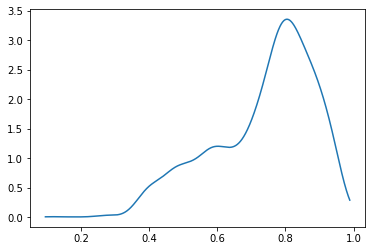

In [145]:
from scipy.stats import gaussian_kde
i=0
kde1 = gaussian_kde(undp_reduced.iloc[:, i].dropna(), bw_method='scott')
x = np.linspace(undp_reduced.iloc[:, i].dropna().min(), undp_reduced.iloc[:, i].dropna().max(), num=1000)
plt.plot(x, kde1.pdf(x))
x[np.argmax(kde1.pdf(x))]

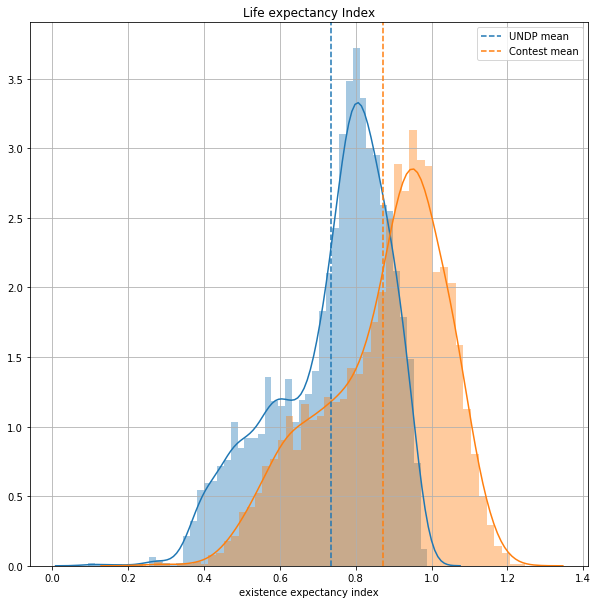

blue std = 0.150310507192437
blue mean = 0.7358885010665102
blue median = 0.774
blue min = 0.095
blue max = 0.989 

red std = 0.16279757508759315
red mean = 0.8723338332658475
red median = 0.9075385989202893
red min = 0.2278895010882802
red max = 1.2469083702468475


In [155]:
i = 0
colors = sns.color_palette()
plt.figure(figsize=(10,10))
# hist1 = plt.hist(undp_reduced.iloc[:, i], color='b', label='UNDP', bins=50)
# hist2 = plt.hist(data_train_cl_no_world.iloc[:, i], color='r', alpha=0.5, label='Contest', bins=50)
ax1 = sns.distplot(undp_reduced.iloc[:, i], bins = 50)
ax2 = sns.distplot(data_train_cl_no_world.iloc[:, i], bins= 50)

# peak1 = (hist1[1][np.argmax(hist1[0])]
#          + hist1[1][np.argmax(hist1[0])+1])/2
# peak2 = (hist2[1][np.argmax(hist2[0])]
#          + hist2[1][np.argmax(hist2[0])+1])/2

# max1 = np.nanpercentile(undp_reduced.iloc[:, i], 100)
# max2 = np.nanpercentile(data_train_cl_no_world.iloc[:, i].max(), 100)

# k = (peak2 - max2) / (peak1 - max1)
# c = peak2 - peak1*k

# plt.axvline(x=peak1, color='b', ls='-')
# plt.axvline(x=peak2, color='r', ls='-')

# plt.hist(k*undp_reduced.iloc[:, i] + c, alpha=0.5, color='c', label='Shifted UNDP', bins=50)
plt.axvline(x=undp_reduced.iloc[:, i].mean(), color=colors[0], ls='--', label='UNDP mean')
plt.axvline(x=data_train_cl_no_world.iloc[:, i].mean(), color=colors[1], ls='--', label='Contest mean')
#plt.axvline(x=(undp_reduced.iloc[:, i] + 0.2*undp_reduced.iloc[:, i].median()).median(), color='y', ls='--')

plt.grid()
plt.title(undp_reduced.columns[i])
plt.legend()
plt.show()
# print('k =', k)
# print('c =', c)

print('blue std =', np.std(undp_reduced.iloc[:, i]))
print('blue mean =', undp_reduced.iloc[:, i].mean())
print('blue median =', undp_reduced.iloc[:, i].median())
print('blue min =', undp_reduced.iloc[:, i].min())
print('blue max =', undp_reduced.iloc[:, i].max(), '\n')

print('red std =', np.std(data_train_cl_no_world.iloc[:, i]))
print('red mean =', data_train_cl_no_world.iloc[:, i].mean())
print('red median =', data_train_cl_no_world.iloc[:, i].median())
print('red min =', data_train_cl_no_world.iloc[:, i].min())
print('red max =', data_train_cl_no_world.iloc[:, i].max())

